<a href="https://colab.research.google.com/github/danielkorat/dynamic_ds/blob/main/Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from collections import defaultdict
from numpy import log
import numpy as np

from nlp.dataset import plot_frequencies, plot_roc
from nlp.model import train_simple_model
from count_min_param import CountMinEvaluation
from cutoff_count_min_param import LearnedCountMinEvaluation
from plotting.plot_loss_vs_space import PlotLossVsSpace
from torch.optim import Adam

In [15]:
DS_ITEM_COUNTS_PATH = './nlp/data/2_grams_wikicorpus_concat_2.0%.npz'
DS_NAME = 'wikicorpus'

In [3]:
### get ngrams for wiki. we only used 10% of the data as dataset is huge. only run if necessary... ###

#get_ngram_counts('wikicorpus', limit_prop=0.1, n=2, tokens_key='sentence', name='tagged_en')

# actual bigrams frequency

there are 811477 bigrams


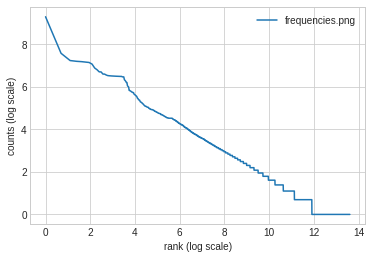

In [17]:
import numpy as np
counts = np.load(DS_ITEM_COUNTS_PATH)['y']
print(f'there are {len(counts)} bigrams')
plot_frequencies(counts, 'rank (log scale)', 'counts (log scale)', 'frequencies.png')

In [9]:
indices = np.argsort(counts)
bigrams = np.load(DS_ITEM_COUNTS_PATH)['x']

print('Top 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[-5:]], counts[indices[-5:]])))

print('Bottom 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[:5]], counts[indices[:5]])))

Top 5 frequent bigrams and their counts:
[('100 females', 648), ('external link', 653), ('65 years', 660), ('median income', 951), ('external links', 5378)]
Bottom 5 frequent bigrams and their counts:
[('mass practice', 1), ('bwv 149', 1), ('bwv 19', 1), ('bwv 130', 1), ('bwv 10', 1)]


# evaluating original count-min and count-sketch algorithms on data

In [10]:
### count sketch ###

DATA = DS_ITEM_COUNTS_PATH
SAVE ='cmin_wikicorpus' #save_results to path
SEED = 69
N_HASHES = [1,2,3,4] 
SPACE_LIST = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.6,1.8,2,3,4] #in MB
N_WORKERS = 22 #n_processes used 
DATA_NAME ='wikicorpus' # determines which script for loading counts is used
COUNT_SKETCH = True

In [ ]:
cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

In [11]:
### count min ###

COUNT_SKETCH = False

cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for ./nlp/data/2_grams_wikicorpus_concat_1.0%.npz
data #: 444662, shape (444662,)
positive ratio: 1.49313, max 5378.000000, min 1.000000


count_min: # hashes 1, # buckets 50000 - loss 13.25	 time: 8.21 sec
count_min: # hashes 1, # buckets 175000 - loss 3.75	 time: 8.20 sec
count_min: # hashes 1, # buckets 500000 - loss 1.30	 time: 8.14 sec
count_min: # hashes 1, # buckets 400000 - loss 1.61	 time: 8.16 sec

count_min: # hashes 1, # buckets 225000 - loss 2.89	 time: 8.21 sec
count_min: # hashes 1, # buckets 150000 - loss 4.38	 time: 8.24 sec
count_min: # hashes 1, # buckets 75000 - loss 8.78	 time: 8.27 seccount_min: # hashes 1, # buckets 200000 - loss 3.27	 time: 8.27 sec
count_min: # hashes 1, # buckets 750000 - loss 0.86	 time: 8.22 sec
count_min: # hashes 1, # buckets 100000 - loss 6.54	 time: 8.34 sec
count_min: # hashes 1, # buckets 25000 - loss 26.30	 time: 8.37 sec
count_min: # hashes 1, # buckets 125000 - loss 5.21	 time: 8.39 sec
count_min: # hashes 1, # buckets 45

# train estimation model

In [3]:
model = train_simple_model(DS_NAME, 
    config={
        "limit_prop": 0.01,
        "concat": True,
        'num_workers': 10,

        "hidden_dim": 128,
        "dropout_prob": 0.0,

        "optim": Adam,
        "learning_rate": 0.0001,
        "batch_size": 128
        },
    args={
#         'gpus': 2,
        'max_epochs': 60
        })

Global seed set to 1234




HYPERPARAMS
-----------
{'args': {'max_epochs': 60}}
{'config': {'batch_size': 128,
            'concat': True,
            'dropout_prob': 0.0,
            'hidden_dim': 128,
            'learning_rate': 0.0001,
            'limit_prop': 0.01,
            'num_workers': 22,
            'optim': <class 'torch.optim.adam.Adam'>}}
{'ds_name': 'wikicorpus'}




GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Loading WikiBigramsDataModule from cache...
np_cache_file: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.0%.npz
features_cache: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.0%_features.npz
Loading WikiBigramsDataModule from cache...
np_cache_file: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.0%.npz
features_cache: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.0%_features.npz



  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | l1        | Linear  | 25.7 K
2 | dropout   | Dropout | 0     
3 | l2        | Linear  | 129   
--------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.103     Total estimated model params size (MB)


Epoch 0:  82%|████████▏ | 2432/2954 [00:24<00:05, 101.11it/s, loss=0.221, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 1:  82%|████████▏ | 2432/2954 [00:23<00:05, 102.27it/s, loss=0.218, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 2:  82%|████████▏ | 2432/2954 [00:23<00:05, 102.39it/s, loss=0.215, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 3:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.15it/s, loss=0.213, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.04it/s, loss=0.211, v_num=37]
Validating: 0it [00:00, ?it/s]
Validating:  40%|████      | 210/522 [00:02<00:23, 13.05it/s]


Epoch 5:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.26it/s, loss=0.209, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  82%|████████▏ | 2432/2954 [00:23<00:05, 103.24it/s, loss=0.207, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 7:  82%|████████▏ | 2432/2954 [00:23<00:05, 102.62it/s, loss=0.206, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 8:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.33it/s, loss=0.204, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 9:  82%|████████▏ | 2432/2954 [00:24<00:05, 101.24it/s, loss=0.202, v_num=37]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/522 [00:00<?, ?it/s]


Epoch 10:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.34it/s, loss=0.201, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 11:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.73it/s, loss=0.2, v_num=37]   
Validating: 0it [00:00, ?it/s]
Epoch 12:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.52it/s, loss=0.198, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 13:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.57it/s, loss=0.197, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 13:  94%|█████████▍| 2772/2954 [00:26<00:01, 102.70it/s, loss=0.197, v_num=37]


Epoch 14:  82%|████████▏ | 2432/2954 [00:25<00:05, 95.74it/s, loss=0.196, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 15:  82%|████████▏ | 2432/2954 [00:23<00:05, 102.18it/s, loss=0.195, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 16:  82%|████████▏ | 2432/2954 [00:23<00:04, 104.65it/s, loss=0.194, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 17:  82%|████████▏ | 2432/2954 [00:23<00:05, 102.20it/s, loss=0.193, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 18:  82%|████████▏ | 2432/2954 [00:23<00:05, 101.71it/s, loss=0.192, v_num=37]
Validating: 0it [00:00, ?it/s]
Validating:  15%|█▍        | 78/522 [00:01<03:19,  2.23it/s]


Epoch 19:  82%|████████▏ | 2432/2954 [00:23<00:05, 103.22it/s, loss=0.191, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 20:  82%|████████▏ | 2432/2954 [00:23<00:04, 104.91it/s, loss=0.19, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 21:  82%|████████▏ | 2432/2954 [00:23<00:05, 101.78it/s, loss=0.189, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 22:  82%|████████▏ | 2432/2954 [00:22<00:04, 105.89it/s, loss=0.189, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 22:  97%|█████████▋| 2871/2954 [00:26<00:00, 109.14it/s, loss=0.189, v_num=37]


Epoch 23:  82%|████████▏ | 2432/2954 [00:29<00:06, 81.81it/s, loss=0.188, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 24:  82%|████████▏ | 2432/2954 [00:23<00:05, 103.90it/s, loss=0.187, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 25:  82%|████████▏ | 2432/2954 [00:23<00:05, 102.64it/s, loss=0.187, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 26:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.64it/s, loss=0.186, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 27:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.95it/s, loss=0.185, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 27:  88%|████████▊ | 2607/2954 [00:26<00:03, 98.63it/s, loss=0.185, v_num=37]


Epoch 28:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.23it/s, loss=0.185, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 29:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.64it/s, loss=0.184, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 30:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.57it/s, loss=0.183, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 31:  82%|████████▏ | 2432/2954 [00:24<00:05, 98.08it/s, loss=0.183, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 32:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.90it/s, loss=0.182, v_num=37]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/522 [00:00<?, ?it/s]


Epoch 33:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.34it/s, loss=0.181, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 34:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.60it/s, loss=0.181, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 35:  82%|████████▏ | 2432/2954 [00:23<00:05, 102.14it/s, loss=0.18, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 36:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.84it/s, loss=0.179, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 36:  92%|█████████▏| 2706/2954 [00:26<00:02, 100.93it/s, loss=0.179, v_num=37]


Epoch 37:  82%|████████▏ | 2432/2954 [00:25<00:05, 96.44it/s, loss=0.179, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 38:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.75it/s, loss=0.178, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 39:  82%|████████▏ | 2432/2954 [00:23<00:05, 102.00it/s, loss=0.178, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 40:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.11it/s, loss=0.177, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 41:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.09it/s, loss=0.176, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 41:  85%|████████▍ | 2508/2954 [00:26<00:04, 94.71it/s, loss=0.176, v_num=37]


Epoch 42:  82%|████████▏ | 2432/2954 [00:24<00:05, 101.23it/s, loss=0.176, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 43:  82%|████████▏ | 2432/2954 [00:24<00:05, 101.17it/s, loss=0.175, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 44:  82%|████████▏ | 2432/2954 [00:23<00:05, 103.55it/s, loss=0.175, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 45:  82%|████████▏ | 2432/2954 [00:23<00:05, 102.55it/s, loss=0.174, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 45:  97%|█████████▋| 2871/2954 [00:27<00:00, 105.73it/s, loss=0.174, v_num=37]


Epoch 46:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.89it/s, loss=0.174, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 47:  82%|████████▏ | 2432/2954 [00:23<00:05, 101.73it/s, loss=0.173, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 48:  82%|████████▏ | 2432/2954 [00:23<00:05, 102.25it/s, loss=0.173, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 49:  82%|████████▏ | 2432/2954 [00:24<00:05, 101.15it/s, loss=0.172, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 50:  82%|████████▏ | 2432/2954 [00:23<00:05, 102.14it/s, loss=0.172, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 50:  87%|████████▋ | 2574/2954 [00:26<00:03, 98.92it/s, loss=0.172, v_num=37]


Epoch 51:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.74it/s, loss=0.171, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 52:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.04it/s, loss=0.17, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 53:  82%|████████▏ | 2432/2954 [00:24<00:05, 97.61it/s, loss=0.17, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 54:  82%|████████▏ | 2432/2954 [00:24<00:05, 98.48it/s, loss=0.169, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 54:  99%|█████████▉| 2937/2954 [00:28<00:00, 103.39it/s, loss=0.169, v_num=37]


Epoch 55:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.36it/s, loss=0.169, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 56:  82%|████████▏ | 2432/2954 [00:23<00:04, 104.46it/s, loss=0.168, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 57:  82%|████████▏ | 2432/2954 [00:24<00:05, 99.31it/s, loss=0.168, v_num=37] 
Validating: 0it [00:00, ?it/s]
Epoch 58:  82%|████████▏ | 2432/2954 [00:24<00:05, 100.11it/s, loss=0.167, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 59:  82%|████████▏ | 2432/2954 [00:24<00:05, 101.18it/s, loss=0.167, v_num=37]
Validating: 0it [00:00, ?it/s]
Epoch 59:  90%|█████████ | 2673/2954 [00:26<00:02, 99.99it/s, loss=0.167, v_num=37]


Epoch 59: 100%|██████████| 2954/2954 [00:27<00:00, 105.61it/s, loss=0.167, v_num=37]
Loading WikiBigramsDataModule from cache...
np_cache_file: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.0%.npz
features_cache: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.0%_features.npz
Testing: 100%|██████████| 522/522 [00:03<00:00, 131.80it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.15831498801708221}
--------------------------------------------------------------------------------
dumping test train and validation to:
true_wikicorpus_test.npz true_wikicorpus_valid.npz true_wikicorpus_train.npz
dumping test train and validation predictions to:
pred_wikicorpus.npz


HYPERPARAMS
-----------
{'args': {'max_epochs': 60}}
{'config': {'batch_size': 128,
            'concat': True,
            'dropout_prob': 0.0,
            'hidden_dim': 128,
            'learning_rate': 

In [23]:
# with lookup

TEST_RESULTS =['./nlp/pred_wikicorpus.npz']
VALID_RESULTS=['./nlp/pred_wikicorpus.npz']
TEST_DATA=['./nlp/true_wikicorpus_test.npz']
VALID_DATA=['./nlp/true_wikicorpus_valid.npz']
LOOKUP_DATA=['./nlp/true_wikicorpus_train.npz']
SAVE='cmin_wikicorpus'
SEED= 69
SPACE_LIST=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 4]
N_HASHES_LIST=[1, 2, 3, 4]
PERFECT_ORDER=False
N_WORKERS = 20
DATA_NAME='wikicorpus'
COUNT_SKETCH = False


lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

#lcm.run()

In [24]:
plot_roc(TEST_RESULTS[0], TEST_DATA[0], 'wiki_roc.png', 'test_output', 0.01)

FileNotFoundError: [Errno 2] No such file or directory: './nlp/pred_wikicorpus.npz'

In [10]:
# no lookup, only using learned model
LOOKUP_DATA2 = None


lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-fd55a830-765e-42ea-a74b-39f8d262b1c6.json

statistics for valid data:
./true_wikicorpus_valid.npz
data #: 66699, shape (66699,)
positive ratio: 1.48596, max 416.000000, min 1.000000


statistics for test data:
./true_wikicorpus_test.npz
data #: 66699, shape (66699,)
positive ratio: 1.45734, max 324.000000, min 1.000000


data loading time: 0.1 sec
	loss_cf 0.00	loss_rd 1.59	loss_avg 0.51
cutoff_count_min_param: bcut: 40000, # hashes 1, # buckets 60000 - loss 0.51	 time: 0.72 sec
	loss_cf 0.00	loss_rd 5.25	loss_avg 2.09
cutoff_count_min_param: bcut: 33750, # hashes 1, # buckets 41250 - loss 2.09	 time: 0.88 sec
	loss_cf 0.00	loss_rd 1.09	loss_avg 0.49
cutoff_count_min_param: bcut: 30000, # hashes 1, # buckets 70000 - loss 0.49	 time: 0.90 sec
	loss_cf 0.00	loss_rd 2.14	loss_avg 1.05
cutoff_count_min_param: bcut: 26250, # hashes 1, # bucket

cutoff_count_min_param: bcut: 6250, # hashes 3, # buckets 43750 - loss 0.52	 time: 2.00 sec
	loss_cf 0.00	loss_rd 13.32	loss_avg 10.23
cutoff_count_min_param: bcut: 6250, # hashes 3, # buckets 10416 - loss 10.23	 time: 2.05 sec
	loss_cf 0.00	loss_rd 1.65	loss_avg 1.37
cutoff_count_min_param: bcut: 3750, # hashes 3, # buckets 26250 - loss 1.37	 time: 2.09 sec
	loss_cf 0.00	loss_rd 2.01	loss_avg 0.90
cutoff_count_min_param: bcut: 30000, # hashes 4, # buckets 40000 - loss 0.90	 time: 1.62 sec
	loss_cf 0.00	loss_rd 3.27	loss_avg 2.61
cutoff_count_min_param: bcut: 5000, # hashes 3, # buckets 18333 - loss 2.61	 time: 2.15 sec
	loss_cf 0.00	loss_rd 7.60	loss_avg 6.76
cutoff_count_min_param: bcut: 1250, # hashes 3, # buckets 8750 - loss 6.76	 time: 2.17 sec
	loss_cf 0.00	loss_rd 9.60	loss_avg 7.96
cutoff_count_min_param: bcut: 3750, # hashes 3, # buckets 9583 - loss 7.96	 time: 2.06 sec
	loss_cf 0.00	loss_rd 5.06	loss_avg 2.50
cutoff_count_min_param: bcut: 26250, # hashes 4, # buckets 31875 - 

cutoff_count_min_param: bcut: 5000, # hashes 3, # buckets 35000 - loss 0.82	 time: 1.99 sec
	loss_cf 0.00	loss_rd 0.71	loss_avg 0.36
cutoff_count_min_param: bcut: 25000, # hashes 3, # buckets 50000 - loss 0.36	 time: 1.46 sec
	loss_cf 0.00	loss_rd 3.60	loss_avg 2.38
cutoff_count_min_param: bcut: 12500, # hashes 2, # buckets 25000 - loss 2.38	 time: 1.42 sec
	loss_cf 0.00	loss_rd 23.35	loss_avg 16.15
cutoff_count_min_param: bcut: 10000, # hashes 2, # buckets 12500 - loss 16.15	 time: 1.53 sec
	loss_cf 0.00	loss_rd 1.37	loss_avg 0.70
cutoff_count_min_param: bcut: 25000, # hashes 3, # buckets 41666 - loss 0.70	 time: 1.41 sec
	loss_cf 0.00	loss_rd 2.26	loss_avg 1.94
cutoff_count_min_param: bcut: 2500, # hashes 2, # buckets 25000 - loss 1.94	 time: 1.64 sec
	loss_cf 0.00	loss_rd 25.71	loss_avg 13.82
cutoff_count_min_param: bcut: 22500, # hashes 3, # buckets 24166 - loss 13.82	 time: 1.53 sec
	loss_cf 0.00	loss_rd 0.59	loss_avg 0.39
cutoff_count_min_param: bcut: 12500, # hashes 2, # buckets

cutoff_count_min_param: bcut: 37500, # hashes 2, # buckets 62500 - loss 0.22	 time: 0.94 sec
	loss_cf 0.00	loss_rd 0.42	loss_avg 0.27
cutoff_count_min_param: bcut: 15000, # hashes 2, # buckets 75000 - loss 0.27	 time: 1.42 sec
	loss_cf 0.00	loss_rd 0.31	loss_avg 0.09
cutoff_count_min_param: bcut: 43750, # hashes 1, # buckets 131250 - loss 0.09	 time: 0.73 sec
	loss_cf 0.00	loss_rd 0.42	loss_avg 0.21
cutoff_count_min_param: bcut: 26250, # hashes 1, # buckets 148750 - loss 0.21	 time: 0.88 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 78750, # hashes 1, # buckets 96250 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.12	loss_avg 0.01
cutoff_count_min_param: bcut: 60000, # hashes 4, # buckets 67500 - loss 0.01	 time: 0.54 sec
	loss_cf 0.00	loss_rd 0.04	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.33	loss_avg 0.09cutoff_count_min_param: bcut: 61250, # hashes 2, # buckets 87500 - loss 0.00	 time: 0.44 sec

cutoff_count_min_param: bcut: 45000, # hashes 3, # buckets 6

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param: bcut: 30000, # hashes 4, # buckets 52500 - loss 0.23	 time: 1.48 sec

cutoff_count_min_param: bcut: 70000, # hashes 3, # buckets 81666 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.97	loss_avg 0.34
cutoff_count_min_param: bcut: 37500, # hashes 4, # buckets 50000 - loss 0.34	 time: 1.27 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00
cutoff_count_min_param: bcut: 60000, # hashes 4, # buckets 80000 - loss 0.00	 time: 0.57 sec
	loss_cf 0.00	loss_rd 0.22	loss_avg 0.13
cutoff_count_min_param: bcut: 20000, # hashes 2, # buckets 100000 - loss 0.13	 time: 1.51 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 90000, # hashes 2, # buckets 100000 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 101250, # hashes 3, # buckets 108750 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.24	loss_avg 0.04
cutoff_count_min_param: bcut: 52500, # hashes 2, # buckets

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 67500, # hashes 4, # buckets 90000 - loss 0.00	 time: 0.32 sec
	loss_cf 0.00	loss_rd 0.13	loss_avg 0.03
cutoff_count_min_param: bcut: 45000, # hashes 1, # buckets 255000 - loss 0.03	 time: 0.63 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 75000, # hashes 2, # buckets 150000 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.51	loss_avg 0.27
cutoff_count_min_param: bcut: 22500, # hashes 1, # buckets 127500 - loss 0.27	 time: 0.97 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 87500, # hashes 2, # buckets 125000 - loss 0.00	 time: 0.36 sec
	loss_cf 0.00	loss_rd 0.25	loss_avg 0.16
cutoff_count_min_param: bcut: 15000, # hashes 1, # buckets 285000 - loss 0.16	 time: 1.03 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.09	loss_avg 0.02

cutoff_count_min_param: bcut: 112500, # hashes 1, # buckets 137500 - loss 0.00	 time: 0.35 sec
cutoff_count_m

cutoff_count_min_param: bcut: 90000, # hashes 4, # buckets 120000 - loss 0.00	 time: 0.33 sec	loss_cf 0.00	loss_rd 0.30	loss_avg 0.14

cutoff_count_min_param: bcut: 30000, # hashes 1, # buckets 170000 - loss 0.14	 time: 0.82 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 70000, # hashes 3, # buckets 140000 - loss 0.00	 time: 0.37 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 135000, # hashes 4, # buckets 142500 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 105000, # hashes 3, # buckets 151666 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 120000, # hashes 3, # buckets 140000 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.21	loss_avg 0.14
cutoff_count_min_param: bcut: 11250, # hashes 4, # buckets 61875 - loss 0.14	 time: 2.10 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 62500, # hashes 4, # bu

cutoff_count_min_param: bcut: 20000, # hashes 2, # buckets 200000 - loss 0.03	 time: 1.27 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 180000, # hashes 3, # buckets 193333 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 90000, # hashes 1, # buckets 360000 - loss 0.00	 time: 0.33 sec	loss_cf 0.00	loss_rd 0.26	loss_avg 0.10

cutoff_count_min_param: bcut: 35000, # hashes 4, # buckets 61250 - loss 0.10	 time: 1.44 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 60000, # hashes 3, # buckets 120000 - loss 0.00	 time: 0.51 sec
	loss_cf 0.00	loss_rd 0.31	loss_avg 0.19
cutoff_count_min_param: bcut: 17500, # hashes 3, # buckets 64166 - loss 0.19	 time: 1.64 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 135000, # hashes 1, # buckets 315000 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 80000, # hashes 1, # buck

cutoff_count_min_param: bcut: 112500, # hashes 2, # buckets 225000 - loss 0.00	 time: 0.33 sec
cutoff_count_min_param: bcut: 125000, # hashes 4, # buckets 187500 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 150000, # hashes 1, # buckets 600000 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 75000, # hashes 4, # buckets 162500 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 202500, # hashes 1, # buckets 247500 - loss 0.00	 time: 0.33 sec	loss_cf 0.00	loss_rd 0.20	loss_avg 0.09

cutoff_count_min_param: bcut: 30000, # hashes 4, # buckets 65000 - loss 0.09	 time: 1.53 sec
	loss_cf 0.00	loss_rd 0.15	loss_avg 0.08
cutoff_count_min_param: bcut: 22500, # hashes 3, # buckets 82500 - loss 0.08	 time: 1.52 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 157500, # hashes 2, # buckets 225000 - loss 0.00	 time: 0.33 sec

cutoff_count_min_param: bcut: 112500, # hashes 2, # buckets 375000 - loss 0.00	 time: 0.34 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param: bcut: 150000, # hashes 2, # buckets 500000 - loss 0.00	 time: 0.32 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 67500, # hashes 2, # buckets 225000 - loss 0.00	 time: 0.32 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 450000, # hashes 1, # buckets 550000 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.03	loss_avg 0.02
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param: bcut: 20000, # hashes 4, # buckets 110000 - loss 0.02	 time: 1.83 sec

cutoff_count_min_param: bcut: 300000, # hashes 4, # buckets 337500 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 200000, # hashes 4, # buckets 225000 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 187500, # hashes 2, 

cutoff_count_min_param: bcut: 22500, # hashes 4, # buckets 123750 - loss 0.01	 time: 1.69 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 100000, # hashes 2, # buckets 500000 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00
cutoff_count_min_param: bcut: 40000, # hashes 3, # buckets 146666 - loss 0.00	 time: 1.04 sec
	loss_cf 0.00	loss_rd 0.04	loss_avg 0.01
cutoff_count_min_param: bcut: 50000, # hashes 1, # buckets 450000 - loss 0.01	 time: 0.56 sec
	loss_cf 0.00	loss_rd 0.05	loss_avg 0.02
cutoff_count_min_param: bcut: 30000, # hashes 4, # buckets 90000 - loss 0.02	 time: 1.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 37500, # hashes 4, # buckets 206250 - loss 0.00	 time: 1.30 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 100000, # hashes 3, # buckets 366666 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 100000, # hashes 4, # bu

In [11]:
# perfect oracle
LOOKUP_DATA3=None
PERFECT_ORDER=True


lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-fd55a830-765e-42ea-a74b-39f8d262b1c6.json

statistics for valid data:
./true_wikicorpus_valid.npz
data #: 66699, shape (66699,)
positive ratio: 1.48596, max 416.000000, min 1.000000


statistics for test data:
./true_wikicorpus_test.npz
data #: 66699, shape (66699,)
positive ratio: 1.45734, max 324.000000, min 1.000000


data loading time: 0.1 sec
	loss_cf 0.00	loss_rd 1.33	loss_avg 0.36
cutoff_count_min_param_perfect: bcut: 40000, # hashes 1, # buckets 60000 - loss 0.36	 time: 0.72 sec
	loss_cf 0.00	loss_rd 0.92	loss_avg 0.34
cutoff_count_min_param_perfect: bcut: 30000, # hashes 1, # buckets 70000 - loss 0.34	 time: 0.83 sec
	loss_cf 0.00	loss_rd 4.40	loss_avg 1.46
cutoff_count_min_param_perfect: bcut: 33750, # hashes 1, # buckets 41250 - loss 1.46	 time: 0.85 sec
	loss_cf 0.00	loss_rd 0.78	loss_avg 0.37
cutoff_count_min_param_perfect: b

	loss_cf 0.00	loss_rd 19.83	loss_avg 12.02
cutoff_count_min_param_perfect: bcut: 8750, # hashes 3, # buckets 11250 - loss 12.02	 time: 1.95 sec
	loss_cf 0.00	loss_rd 13.39	loss_avg 4.45
cutoff_count_min_param_perfect: bcut: 33750, # hashes 4, # buckets 35625 - loss 4.45	 time: 1.57 sec
	loss_cf 0.00	loss_rd 59.73	loss_avg 33.42
cutoff_count_min_param_perfect: bcut: 11250, # hashes 3, # buckets 12083 - loss 33.42	 time: 1.87 sec
	loss_cf 0.00	loss_rd 1.83	loss_avg 0.68
cutoff_count_min_param_perfect: bcut: 30000, # hashes 4, # buckets 40000 - loss 0.68	 time: 1.55 sec
	loss_cf 0.00	loss_rd 1.59	loss_avg 1.14
cutoff_count_min_param_perfect: bcut: 3750, # hashes 3, # buckets 26250 - loss 1.14	 time: 2.08 sec
	loss_cf 0.00	loss_rd 12.11	loss_avg 7.96
cutoff_count_min_param_perfect: bcut: 6250, # hashes 3, # buckets 10416 - loss 7.96	 time: 2.04 sec
	loss_cf 0.00	loss_rd 0.66	loss_avg 0.43
cutoff_count_min_param_perfect: bcut: 6250, # hashes 3, # buckets 43750 - loss 0.43	 time: 1.99 sec
	l

cutoff_count_min_param_perfect: bcut: 30000, # hashes 3, # buckets 35000 - loss 1.89	 time: 1.34 sec
	loss_cf 0.00	loss_rd 4.51	loss_avg 3.08
cutoff_count_min_param_perfect: bcut: 5000, # hashes 1, # buckets 20000 - loss 3.08	 time: 1.21 sec
	loss_cf 0.00	loss_rd 3.74	loss_avg 2.83
cutoff_count_min_param_perfect: bcut: 2500, # hashes 1, # buckets 22500 - loss 2.83	 time: 1.26 sec
	loss_cf 0.00	loss_rd 0.82	loss_avg 0.43
cutoff_count_min_param_perfect: bcut: 15000, # hashes 2, # buckets 50000 - loss 0.43	 time: 1.46 sec
	loss_cf 0.00	loss_rd 3.18	loss_avg 1.74
cutoff_count_min_param_perfect: bcut: 12500, # hashes 2, # buckets 25000 - loss 1.74	 time: 1.49 sec
	loss_cf 0.00	loss_rd 2.25	loss_avg 0.72
cutoff_count_min_param_perfect: bcut: 35000, # hashes 4, # buckets 42500 - loss 0.72	 time: 1.42 sec
	loss_cf 0.00	loss_rd 0.57	loss_avg 0.21
cutoff_count_min_param_perfect: bcut: 31250, # hashes 2, # buckets 62500 - loss 0.21	 time: 1.07 sec
	loss_cf 0.00	loss_rd 1.47	loss_avg 0.76
cutoff_c

cutoff_count_min_param_perfect: bcut: 60000, # hashes 3, # buckets 70000 - loss 0.01	 time: 0.50 sec
	loss_cf 0.00	loss_rd 1.32	loss_avg 0.69
cutoff_count_min_param_perfect: bcut: 15000, # hashes 4, # buckets 32500 - loss 0.69	 time: 2.03 sec
	loss_cf 0.00	loss_rd 0.39	loss_avg 0.23
cutoff_count_min_param_perfect: bcut: 8750, # hashes 1, # buckets 166250 - loss 0.23	 time: 1.11 sec
	loss_cf 0.00	loss_rd 2.52	loss_avg 1.31
cutoff_count_min_param_perfect: bcut: 15000, # hashes 4, # buckets 26250 - loss 1.31	 time: 2.02 sec
	loss_cf 0.00	loss_rd 5.77	loss_avg 3.16
cutoff_count_min_param_perfect: bcut: 12500, # hashes 4, # buckets 18750 - loss 3.16	 time: 2.14 sec
	loss_cf 0.00	loss_rd 0.33	loss_avg 0.13
cutoff_count_min_param_perfect: bcut: 26250, # hashes 1, # buckets 148750 - loss 0.13	 time: 0.97 sec
	loss_cf 0.00	loss_rd 0.66	loss_avg 0.11
cutoff_count_min_param_perfect: bcut: 50000, # hashes 1, # buckets 75000 - loss 0.11	 time: 0.56 sec
	loss_cf 0.00	loss_rd 0.35	loss_avg 0.13
cutof

cutoff_count_min_param_perfect: bcut: 11250, # hashes 1, # buckets 213750 - loss 0.15	 time: 1.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 101250, # hashes 1, # buckets 123750 - loss 0.00	 time: 0.35 sec
	loss_cf 0.00	loss_rd 0.44	loss_avg 0.23
cutoff_count_min_param_perfect: bcut: 15000, # hashes 3, # buckets 55000 - loss 0.23	 time: 1.86 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 70000, # hashes 2, # buckets 87500 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 78750, # hashes 2, # buckets 112500 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 80000, # hashes 4, # buckets 90000 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 1.13	loss_avg 0.19
cutoff_count_min_param_perfect: bcut: 50000, # hashes 4, # buckets 56250 - loss 0.19	 time: 0.91 sec
	loss_cf 0.00	loss_rd 0.41	loss_avg 0.26
cu

cutoff_count_min_param_perfect: bcut: 20000, # hashes 3, # buckets 73333 - loss 0.10	 time: 1.64 sec
	loss_cf 0.00	loss_rd 0.12	loss_avg 0.02
cutoff_count_min_param_perfect: bcut: 52500, # hashes 2, # buckets 87500 - loss 0.02	 time: 0.69 sec
	loss_cf 0.00	loss_rd 0.28	loss_avg 0.04
cutoff_count_min_param_perfect: bcut: 52500, # hashes 4, # buckets 63750 - loss 0.04	 time: 0.88 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 75000, # hashes 4, # buckets 100000 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 90000, # hashes 4, # buckets 101250 - loss 0.00	 time: 0.35 sec
	loss_cf 0.00	loss_rd 0.46	loss_avg 0.29
cutoff_count_min_param_perfect: bcut: 7500, # hashes 3, # buckets 52500 - loss 0.29	 time: 1.96 sec
	loss_cf 0.00	loss_rd 0.24	loss_avg 0.13
	loss_cf 0.00	loss_rd 0.12	loss_avg 0.05cutoff_count_min_param_perfect: bcut: 12500, # hashes 1, # buckets 237500 - loss 0.13	 time: 1.20 sec

cuto

cutoff_count_min_param_perfect: bcut: 135000, # hashes 2, # buckets 150000 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.05
cutoff_count_min_param_perfect: bcut: 15000, # hashes 2, # buckets 150000 - loss 0.05	 time: 1.44 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 105000, # hashes 4, # buckets 127500 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 112500, # hashes 4, # buckets 118750 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.56	loss_avg 0.35
cutoff_count_min_param_perfect: bcut: 7500, # hashes 4, # buckets 41250 - loss 0.35	 time: 2.21 sec
	loss_cf 0.00	loss_rd 0.12	loss_avg 0.04
cutoff_count_min_param_perfect: bcut: 35000, # hashes 1, # buckets 315000 - loss 0.04	 time: 0.83 sec
	loss_cf 0.00	loss_rd 0.02	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 45000, # hashes 3, # buckets 115000 - loss 0.00	 time: 0.92 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.0

cutoff_count_min_param_perfect: bcut: 22500, # hashes 1, # buckets 202500 - loss 0.11	 time: 0.93 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 60000, # hashes 3, # buckets 153333 - loss 0.00	 time: 0.52 sec
	loss_cf 0.00	loss_rd 0.25	loss_avg 0.08
cutoff_count_min_param_perfect: bcut: 35000, # hashes 4, # buckets 61250 - loss 0.08	 time: 1.37 sec
	loss_cf 0.00	loss_rd 0.18	loss_avg 0.07	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param_perfect: bcut: 30000, # hashes 2, # buckets 100000 - loss 0.07	 time: 1.26 seccutoff_count_min_param_perfect: bcut: 180000, # hashes 1, # buckets 220000 - loss 0.00	 time: 0.33 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 100000, # hashes 3, # buckets 166666 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 87500, # hashes 2, # buckets 175000 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.0

cutoff_count_min_param_perfect: bcut: 35000, # hashes 4, # buckets 105000 - loss 0.01	 time: 1.39 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 120000, # hashes 4, # buckets 160000 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 175000, # hashes 1, # buckets 325000 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 135000, # hashes 3, # buckets 195000 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param_perfect: bcut: 75000, # hashes 2, # buckets 250000 - loss 0.00	 time: 0.34 sec

cutoff_count_min_param_perfect: bcut: 125000, # hashes 2, # buckets 250000 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 180000, # hashes 3, # buckets 210000 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg

cutoff_count_min_param_perfect: bcut: 37500, # hashes 4, # buckets 81250 - loss 0.02	 time: 1.27 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param_perfect: bcut: 112500, # hashes 4, # buckets 168750 - loss 0.00	 time: 0.33 seccutoff_count_min_param_perfect: bcut: 150000, # hashes 4, # buckets 262500 - loss 0.00	 time: 0.33 sec


cutoff_count_min_param_perfect: bcut: 100000, # hashes 2, # buckets 250000 - loss 0.00	 time: 0.37 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 75000, # hashes 4, # buckets 225000 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.04	loss_avg 0.02
cutoff_count_min_param_perfect: bcut: 22500, # hashes 2, # buckets 225000 - loss 0.02	 time: 1.31 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 225000, # hashes 2, # buckets 375000 - loss 0.00	 time: 0.36 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0

cutoff_count_min_param_perfect: bcut: 262500, # hashes 2, # buckets 375000 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 112500, # hashes 4, # buckets 243750 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 337500, # hashes 2, # buckets 375000 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.05	loss_avg 0.02	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param_perfect: bcut: 30000, # hashes 3, # buckets 110000 - loss 0.02	 time: 1.28 seccutoff_count_min_param_perfect: bcut: 67500, # hashes 4, # buckets 146250 - loss 0.00	 time: 0.34 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00


cutoff_count_min_param_perfect: bcut: 250000, # hashes 4, # buckets 375000 - loss 0.00	 time: 0.37 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 450000, # hashes 3, # buckets 483333 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.02	loss_avg

cutoff_count_min_param_perfect: bcut: 56250, # hashes 1, # buckets 68750 - loss 0.09	 time: 0.50 sec
	loss_cf 0.00	loss_rd 0.92	loss_avg 0.35
cutoff_count_min_param_perfect: bcut: 30000, # hashes 1, # buckets 70000 - loss 0.35	 time: 0.88 sec
	loss_cf 0.00	loss_rd 1.91	loss_avg 1.13
cutoff_count_min_param_perfect: bcut: 10000, # hashes 1, # buckets 40000 - loss 1.13	 time: 1.03 sec
	loss_cf 0.00	loss_rd 1.05	loss_avg 0.60
cutoff_count_min_param_perfect: bcut: 11250, # hashes 1, # buckets 63750 - loss 0.60	 time: 1.08 sec
	loss_cf 0.00	loss_rd 3.75	loss_avg 2.89
cutoff_count_min_param_perfect: bcut: 2500, # hashes 1, # buckets 22500 - loss 2.89	 time: 1.13 sec
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-fd55a830-765e-42ea-a74b-39f8d262b1c6.json
statistics for valid data:
./true_wikicorpus_valid.npz
data #: 66699, shape (66699,)
positive ratio: 1.48596, max 416.000000, min 1.000000



# plot count min

plot testing results for lookup table
plot testing results for perfect CCM
plot testing results for cutoff cmin


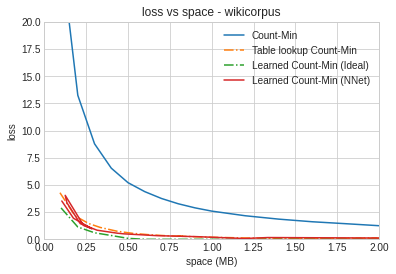

In [13]:
ALGO = 'Count-Min'
COUNT_MIN = 'param_results/count_min/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_min_param/cmin_wikicorpus_test.npz']
PERFECT='param_results/cutoff_count_min_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_min/cmin_wikicorpus_test.npz' 
MODEL_NAMES= ["Learned Count-Min (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES= [0.0052]
LOOKUP_SIZE= [0.0035]
X_LIM= [0,2]
Y_LIM= [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=LOOKUP_TABLE,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()